In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
#from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from scipy.spatial import cKDTree

Skipping torch import


In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore",category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"


In [3]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [4]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/data/Ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/data/Ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/data/Ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/data/Ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID']))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 36] = 0
# c_cases_idx[ids == 42] = 0
# c_cases_idx[ids == 52] = 0
c_cases_idx[ids == 53] = 0
# c_cases_idx[ids == 98] = 0
# c_cases_idx[ids == 108] = 0
print(np.sum(c_cases_idx))
subs[subs <= 90]
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,2:6,:]
#X_all_c = (np.load('X2h_sr.npy').T).reshape((31,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]
phys = cv_dict['Physician'][s_cases_idx]
age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
subsc = subs[s_cases_idx]

# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{' ON (pre-dbs updrs)', 'Race', 'Disease Duration (year)', 'Sex', ' OFF (pre-dbs updrs)', ' pre op levadopa equivalent dose (mg)', ' Target', 'CORNELL ID', 'Ethnicity', ' Test medication status', ' Location', 'Physician', ' OFF meds ON stim 6mo', 'Age'}
['X_115_01.npy', 'X_115_02.npy', 'X_115_03.npy', 'X_115_04.npy', 'X_115_05.npy', 'X_115_06.npy', 'X_115_07.npy', 'X_115_08.npy', 'X_115_09.npy', 'X_115_10.npy', 'X_115_100.npy', 'X_115_101.npy', 'X_115_102.npy', 'X_115_104.npy', 'X_115_105.npy', 'X_115_106.npy', 'X_115_107.npy', 'X_115_108.npy', 'X_115_109.npy', 'X_115_11.npy', 'X_115_110.npy', 'X_115_111.npy', 'X_115_112.npy', 'X_115_113.npy', 'X_115_114.npy', 'X_115_1

In [5]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
r = 1

In [10]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,age,dd,loc,ledd,phys,None,None,None,None,False,False,False)
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    mu = np.zeros_like(y_train)
    sigma = np.zeros_like(y_train)
    
    for i in np.unique(phys):
      (mux, sigmax) = stats.norm.fit(y_train[np.where(phys[train_index] == i)[0]])
      mu[phys[train_index] == i] = mux
      sigma[phys[train_index] == i] = sigmax
    np.random.seed(rs)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        sigma = np.append(sigma,sigma[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train+(sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        sigma = np.hstack((sigma,sigma))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.amax((2,np.argmax(cv_scores)))
      
      # Fit whole dataset with optimal cv
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X_test_sst = sel.transform(X_test_ss0)
        X0_ss = X0_sst
        X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False)
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      if results_ls_aug[c] < 0:
          dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)
          results_ls_aug[c] = y_train[y_n]
          print('Using nearest neighbor')
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
            'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
      try:
        K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      except:
        print('No features appended')
      c=c+1


      

  


LassoCV score for 2 is [0.5612489] from dataset of size (496, 1386)
LassoCV score for 3 is [0.55757898] from dataset of size (496, 2386)
LassoCV score for 4 is [0.56134004] from dataset of size (496, 1386)
Lasso predicts 0.6237 for case with 0.71 and selected CV 4
No features appended
LassoCV score for 2 is [0.55581625] from dataset of size (496, 5386)
LassoCV score for 3 is [0.55619505] from dataset of size (496, 1386)
LassoCV score for 4 is [0.55908908] from dataset of size (496, 3386)
Lasso predicts 0.6106 for case with 0.5 and selected CV 4
No features appended
LassoCV score for 2 is [0.3371581] from dataset of size (496, 386)
LassoCV score for 3 is [0.54256094] from dataset of size (496, 3386)
LassoCV score for 4 is [0.56130666] from dataset of size (496, 2386)
Lasso predicts 0.6988 for case with 0.67 and selected CV 4
No features appended
LassoCV score for 2 is [0.46099713] from dataset of size (496, 6386)
LassoCV score for 3 is [0.46099713] from dataset of size (496, 6386)
Lasso

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:366: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:371: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


LassoCV score for 2 is [0.54491072] from dataset of size (496, 4386)
LassoCV score for 3 is [0.33227614] from dataset of size (496, 386)
LassoCV score for 4 is [0.55540625] from dataset of size (496, 1386)
Lasso predicts 0.8265 for case with 0.74 and selected CV 4
No features appended
LassoCV score for 2 is [0.56008266] from dataset of size (496, 4386)
LassoCV score for 3 is [0.56112067] from dataset of size (496, 3386)
LassoCV score for 4 is [0.55615281] from dataset of size (496, 2386)
Lasso predicts 0.6325 for case with 0.48 and selected CV 3
No features appended
LassoCV score for 2 is [0.56027889] from dataset of size (496, 1386)
LassoCV score for 3 is [0.55521052] from dataset of size (496, 4386)
LassoCV score for 4 is [0.56139034] from dataset of size (496, 1386)
Lasso predicts 0.4775 for case with 0.71 and selected CV 4
No features appended
LassoCV score for 2 is [0.56091561] from dataset of size (496, 3386)
LassoCV score for 3 is [0.2471252] from dataset of size (496, 386)
Lass

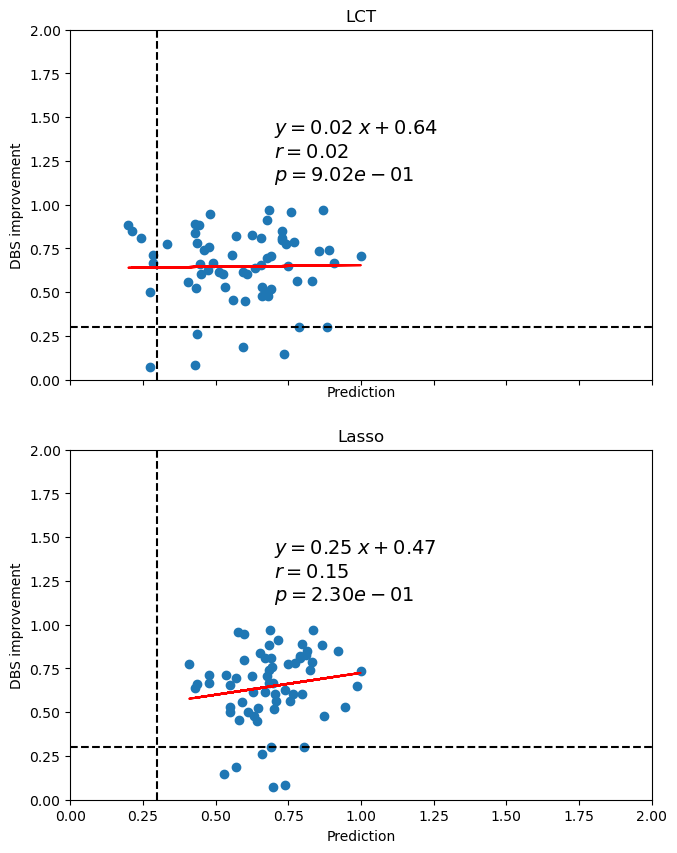

In [11]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')
# Fix nearest neighbor problem
# Fix differing noise problem

In [12]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,age,dd,loc,ledd,phys,None,None,None,None,False,False,False)
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    mu = np.zeros_like(y_train)
    sigma = np.zeros_like(y_train)
    
    for i in np.unique(phys):
      (mux, sigmax) = stats.norm.fit(y_train[np.where(phys[train_index] == i)[0]])
      mu[phys[train_index] == i] = mux
      sigma[phys[train_index] == i] = sigmax
    np.random.seed(rs)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < cvn:
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        sigma = np.append(sigma,sigma[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train#+(sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        sigma = np.hstack((sigma,sigma))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X0_ss = X0_sst
        est_ls = lasso.fit(X0_ss,y_train)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.amax((2,np.argmax(cv_scores)))
      
      # Fit whole dataset with optimal cv
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X_test_sst = sel.transform(X_test_ss0)
        X0_ss = X0_sst
        X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False)
      est_ls = lasso.fit(X0_ss,y_train)
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      if results_ls_aug[c] < 0:
          dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)
          results_ls_aug[c] = y_train[y_n]
          print('Using nearest neighbor')
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
            'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
      try:
        K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      except:
        print('No features appended')
      c=c+1


      

  


LassoCV score for 2 is [0.91612585] from dataset of size (496, 1386)
LassoCV score for 3 is [0.49926246] from dataset of size (496, 386)
LassoCV score for 4 is [0.93560011] from dataset of size (496, 2386)
Lasso predicts 0.5791 for case with 0.71 and selected CV 4
No features appended
LassoCV score for 2 is [0.99859177] from dataset of size (496, 6386)
LassoCV score for 3 is [0.66520415] from dataset of size (496, 386)
LassoCV score for 4 is [0.55244522] from dataset of size (496, 386)
Lasso predicts 0.5881 for case with 0.5 and selected CV 2
No features appended
LassoCV score for 2 is [0.98979153] from dataset of size (496, 1386)
LassoCV score for 3 is [0.99871043] from dataset of size (496, 1386)
LassoCV score for 4 is [0.98213417] from dataset of size (496, 1386)
Lasso predicts 0.83 for case with 0.67 and selected CV 3
No features appended
LassoCV score for 2 is [0.99700672] from dataset of size (496, 1386)
LassoCV score for 3 is [0.99978551] from dataset of size (496, 1386)
LassoCV

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:366: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:371: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


LassoCV score for 2 is [0.89061091] from dataset of size (496, 6386)
LassoCV score for 3 is [0.74906577] from dataset of size (496, 386)
LassoCV score for 4 is [0.74906577] from dataset of size (496, 386)
Lasso predicts 0.7475 for case with 0.74 and selected CV 2
No features appended
LassoCV score for 2 is [0.96337439] from dataset of size (496, 1386)
LassoCV score for 3 is [0.56978652] from dataset of size (496, 386)
LassoCV score for 4 is [0.99886735] from dataset of size (496, 4386)
Lasso predicts 0.6142 for case with 0.48 and selected CV 4
No features appended
LassoCV score for 2 is [0.99435337] from dataset of size (496, 386)
LassoCV score for 3 is [0.37765045] from dataset of size (496, 386)
LassoCV score for 4 is [0.99257679] from dataset of size (496, 2386)
Lasso predicts 0.3631 for case with 0.71 and selected CV 2
No features appended
LassoCV score for 2 is [0.99848632] from dataset of size (496, 1386)
LassoCV score for 3 is [0.99833851] from dataset of size (496, 6386)
LassoC

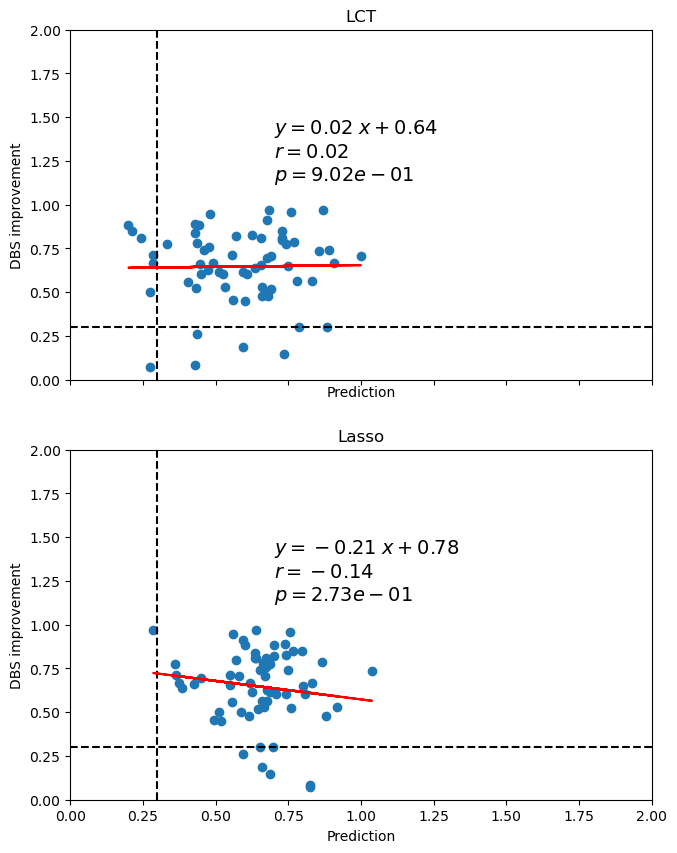

In [15]:
# pre_imp = (np.asarray(pre_updrs_off,dtype=float)-np.asarray(pre_updrs_off,dtype=float))/np.asarray(pre_updrs_off,dtype=float)
# results_ls[results_ls>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


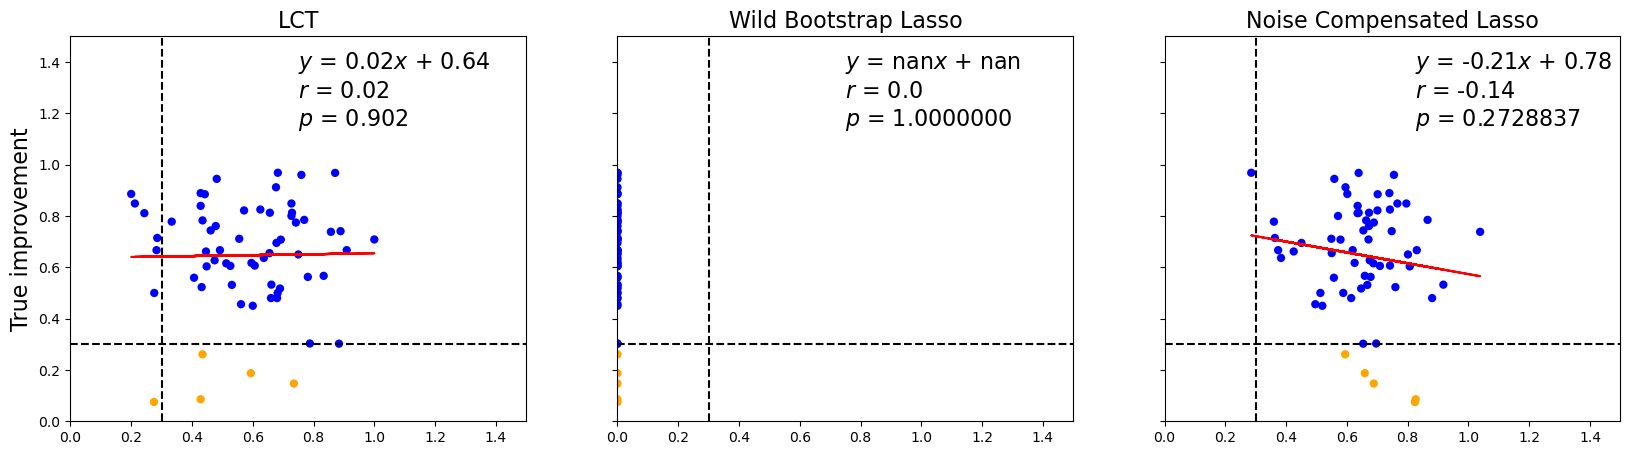

In [16]:
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp.T,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.50,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
ax[1].text(0.50,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Wild Bootstrap Lasso',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[2].plot(results_ls_aug,y_model,color='r')
ax[2].text(1.75,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')

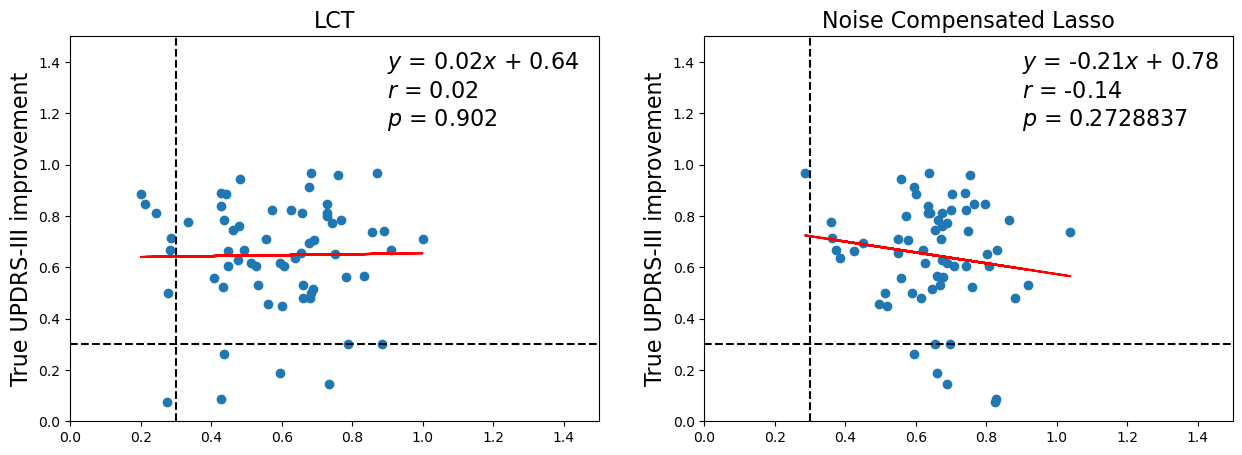

In [17]:
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
plt.rcParams['figure.figsize'] = [15, 5]
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(pre_imp,per_change)
lr = stats.linregress(pre_imp.T,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True UPDRS-III improvement',fontsize=16)

ax[1].scatter(results_ls_aug,per_change)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[1].plot(results_ls_aug,y_model,color='r')
ax[1].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Noise Compensated Lasso',fontsize=16)
ax[1].set_ylabel('True UPDRS-III improvement',fontsize=16)
ax[1].yaxis.set_tick_params(labelleft=True)
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')